In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

np.random.seed(42)

print("=== Experiment 9: Implementing a Neural Network from Scratch ===\n")

=== Experiment 9: Implementing a Neural Network from Scratch ===



# Task 1: Data Loading and Preprocessing

1. Load Data: Load the Breast Cancer Wisconsin dataset directly from scikit-learn.

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target

2. Inspect Data:

In [3]:
print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")
print(f"Feature names: {data.feature_names[:5]}...")  # Show first 5 features
print(f"Class distribution: {np.bincount(y)}")
print(f"Target names: {data.target_names}")

Feature data shape: (569, 30)
Target data shape: (569,)
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']...
Class distribution: [212 357]
Target names: ['malignant' 'benign']


3. Create Hold-Out Set:

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (398, 30)
Validation set shape: (171, 30)


4. Standardize Features:

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print("Feature standardization completed\n")

Feature standardization completed



# Task 2: 'From Scratch' Utilities (NumPy)

1. Activation Functions:

In [6]:
def sigmoid(Z):
    """Compute sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(Z, -250, 250)))


def relu(Z):
    """Compute ReLU activation function"""
    return np.maximum(0, Z)

2. Activation Derivatives: These are crucial for backpropagation.

In [7]:
def sigmoid_derivative(A):
    """Compute derivative of sigmoid given A = sigmoid(Z)"""
    return A * (1 - A)

def relu_derivative(Z):
    """Compute derivative of ReLU"""
    return (Z > 0).astype(float)

3. Loss Functions:

In [8]:
def compute_bce_loss(Y, Y_hat):
    """Compute Binary Cross-Entropy loss"""
    epsilon = 1e-15
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)  # Avoid log(0)
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m
    return np.squeeze(loss)

def compute_mse_loss(Y, Y_hat):
    """Compute Mean Squared Error loss"""
    m = Y.shape[1]
    loss = np.sum((Y_hat - Y) ** 2) / m
    return np.squeeze(loss)

print("Utility functions implemented:")
print("✓ sigmoid, relu, sigmoid_derivative, relu_derivative")
print("✓ compute_bce_loss, compute_mse_loss\n")

Utility functions implemented:
✓ sigmoid, relu, sigmoid_derivative, relu_derivative
✓ compute_bce_loss, compute_mse_loss



# Task 3: 'From Scratch' ANN Classifier

In [9]:
class MyANNClassifier:
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'):
        """
        Initialize the neural network

        Parameters:
        - layer_dims: list of layer dimensions [input_dim, hidden1_dim, ..., output_dim]
        - learning_rate: learning rate for gradient descent
        - n_iterations: number of training iterations
        - loss: loss function ('bce' or 'mse')
        """
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters_ = {}
        self.costs_ = []

    def __initialize_parameters__(self):
        """Initialize weights and biases"""
        np.random.seed(42)
        L = len(self.layer_dims)

        for l in range(1, L):
            # He initialization for ReLU
            self.parameters_[f'W{l}'] = np.random.randn(
                self.layer_dims[l], self.layer_dims[l-1]) * np.sqrt(2. / self.layer_dims[l-1])
            self.parameters_[f'b{l}'] = np.zeros((self.layer_dims[l], 1))

    def forward_propagation(self, X):
        """Perform forward propagation through the network"""
        cache = {'A0': X}
        A_prev = X
        L = len(self.layer_dims) - 1  # Number of layers excluding input

        # Hidden layers (ReLU activation)
        for l in range(1, L):
            W = self.parameters_[f'W{l}']
            b = self.parameters_[f'b{l}']
            Z = np.dot(W, A_prev) + b
            A = relu(Z)
            cache[f'Z{l}'] = Z
            cache[f'A{l}'] = A
            A_prev = A

        # Output layer (Sigmoid activation)
        W = self.parameters_[f'W{L}']
        b = self.parameters_[f'b{L}']
        Z = np.dot(W, A_prev) + b
        A_L = sigmoid(Z)
        cache[f'Z{L}'] = Z
        cache[f'A{L}'] = A_L

        return A_L, cache

    def backward_propagation(self, Y, Y_hat, cache):
        """Perform backward propagation to compute gradients"""
        grads = {}
        m = Y.shape[1]
        L = len(self.layer_dims) - 1

        # Initialize backpropagation
        if self.loss == 'bce':
            dA_L = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        elif self.loss == 'mse':
            dA_L = 2 * (Y_hat - Y)
        else:
            raise ValueError("Loss function must be 'bce' or 'mse'")

        # Output layer (Sigmoid)
        A_prev = cache[f'A{L-1}'] if L > 1 else cache['A0']
        Z_L = cache[f'Z{L}']
        A_L = cache[f'A{L}']

        dZ_L = dA_L * sigmoid_derivative(A_L)
        grads[f'dW{L}'] = np.dot(dZ_L, A_prev.T) / m
        grads[f'db{L}'] = np.sum(dZ_L, axis=1, keepdims=True) / m
        dA_prev = np.dot(self.parameters_[f'W{L}'].T, dZ_L)

        # Hidden layers (ReLU) - backward pass
        for l in reversed(range(1, L)):
            Z_prev = cache[f'Z{l}']
            A_prev_prev = cache[f'A{l-1}'] if l > 1 else cache['A0']

            dZ_prev = dA_prev * relu_derivative(Z_prev)
            grads[f'dW{l}'] = np.dot(dZ_prev, A_prev_prev.T) / m
            grads[f'db{l}'] = np.sum(dZ_prev, axis=1, keepdims=True) / m

            if l > 1:
                dA_prev = np.dot(self.parameters_[f'W{l}'].T, dZ_prev)

        return grads

    def update_parameters(self, grads):
        """Update parameters using gradient descent"""
        L = len(self.layer_dims) - 1

        for l in range(1, L + 1):
            self.parameters_[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']
            self.parameters_[f'b{l}'] -= self.learning_rate * grads[f'db{l}']

    def compute_loss(self, Y, Y_hat):
        """Compute the loss"""
        if self.loss == 'bce':
            return compute_bce_loss(Y, Y_hat)
        elif self.loss == 'mse':
            return compute_mse_loss(Y, Y_hat)

    def fit(self, X, y):
        """Train the neural network"""
        # Reshape data
        X = X.T if X.shape[0] != self.layer_dims[0] else X
        y = y.reshape(1, -1)

        # Initialize parameters
        self.__initialize_parameters__()

        # Training loop
        for i in range(self.n_iterations):
            # Forward propagation
            Y_hat, cache = self.forward_propagation(X)

            # Compute loss
            cost = self.compute_loss(y, Y_hat)
            self.costs_.append(cost)

            # Backward propagation
            grads = self.backward_propagation(y, Y_hat, cache)

            # Update parameters
            self.update_parameters(grads)

            # Print progress
            if i % 500 == 0:
                print(f"Iteration {i}: Loss = {cost:.4f}")

    def predict(self, X):
        """Make predictions"""
        X = X.T if X.shape[0] != self.layer_dims[0] else X
        Y_hat, _ = self.forward_propagation(X)
        predictions = (Y_hat > 0.5).astype(int)
        return predictions.flatten()

    def predict_proba(self, X):
        """Predict probabilities"""
        X = X.T if X.shape[0] != self.layer_dims[0] else X
        Y_hat, _ = self.forward_propagation(X)
        return Y_hat.flatten()

print("MyANNClassifier class implemented successfully!\n")

MyANNClassifier class implemented successfully!



# Task 4: Training and Experimentation

1. Model 1 (BCE Loss):

In [10]:
print("Model 1: BCE Loss with architecture [30, 10, 1]")
model1 = MyANNClassifier(
    layer_dims=[30, 10, 1],
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce'
)
model1.fit(X_train_scaled.T, y_train)
y_pred1 = model1.predict(X_val_scaled)
print("Classification Report - Model 1 (BCE):")
print(classification_report(y_val, y_pred1))
accuracy1 = accuracy_score(y_val, y_pred1)
print(f"Validation Accuracy: {accuracy1:.4f}\n")

Model 1: BCE Loss with architecture [30, 10, 1]
Iteration 0: Loss = 0.7742
Iteration 500: Loss = 0.4912
Iteration 1000: Loss = 0.3599
Iteration 1500: Loss = 0.2851
Iteration 2000: Loss = 0.2394
Iteration 2500: Loss = 0.2095
Iteration 3000: Loss = 0.1880
Iteration 3500: Loss = 0.1720
Iteration 4000: Loss = 0.1597
Iteration 4500: Loss = 0.1494
Classification Report - Model 1 (BCE):
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        64
           1       0.94      0.91      0.92       107

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Validation Accuracy: 0.9064



2. Model 2 (MSE Loss):

In [11]:
print("Model 2: MSE Loss with architecture [30, 10, 1]")
model2 = MyANNClassifier(
    layer_dims=[30, 10, 1],
    learning_rate=0.001,
    n_iterations=5000,
    loss='mse'
)
model2.fit(X_train_scaled.T, y_train)
y_pred2 = model2.predict(X_val_scaled)
print("Classification Report - Model 2 (MSE):")
print(classification_report(y_val, y_pred2))
accuracy2 = accuracy_score(y_val, y_pred2)
print(f"Validation Accuracy: {accuracy2:.4f}\n")

Model 2: MSE Loss with architecture [30, 10, 1]
Iteration 0: Loss = 0.2845
Iteration 500: Loss = 0.2093
Iteration 1000: Loss = 0.1624
Iteration 1500: Loss = 0.1323
Iteration 2000: Loss = 0.1114
Iteration 2500: Loss = 0.0968
Iteration 3000: Loss = 0.0863
Iteration 3500: Loss = 0.0786
Iteration 4000: Loss = 0.0726
Iteration 4500: Loss = 0.0678
Classification Report - Model 2 (MSE):
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        64
           1       0.94      0.86      0.90       107

    accuracy                           0.88       171
   macro avg       0.87      0.88      0.87       171
weighted avg       0.88      0.88      0.88       171

Validation Accuracy: 0.8772



3. Model 3 (Deeper Architecture):

In [12]:
print("Model 3: BCE Loss with architecture [30, 10, 5, 1]")
model3 = MyANNClassifier(
    layer_dims=[30, 10, 5, 1],
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce'
)
model3.fit(X_train_scaled.T, y_train)
y_pred3 = model3.predict(X_val_scaled)
print("Classification Report - Model 3 (Deeper):")
print(classification_report(y_val, y_pred3))
accuracy3 = accuracy_score(y_val, y_pred3)
print(f"Validation Accuracy: {accuracy3:.4f}\n")

Model 3: BCE Loss with architecture [30, 10, 5, 1]
Iteration 0: Loss = 0.6828
Iteration 500: Loss = 0.4766
Iteration 1000: Loss = 0.4143
Iteration 1500: Loss = 0.3798
Iteration 2000: Loss = 0.3546
Iteration 2500: Loss = 0.3339
Iteration 3000: Loss = 0.3164
Iteration 3500: Loss = 0.3011
Iteration 4000: Loss = 0.2873
Iteration 4500: Loss = 0.2744
Classification Report - Model 3 (Deeper):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        64
           1       0.94      0.94      0.94       107

    accuracy                           0.93       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

Validation Accuracy: 0.9298



# Task 5: Comparison with scikit-learn

1. Train MLPClassifier :

In [13]:
mlp = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    max_iter=5000,
    learning_rate_init=0.001,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_val_scaled)

print("Classification Report - scikit-learn MLPClassifier:")
print(classification_report(y_val, y_pred_mlp))
accuracy_mlp = accuracy_score(y_val, y_pred_mlp)
print(f"Validation Accuracy: {accuracy_mlp:.4f}\n")

Classification Report - scikit-learn MLPClassifier:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.99      0.97      0.98       107

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Validation Accuracy: 0.9766



2. Evaluate MLPClassifier :

Generating Visualizations and Final Analysis...
----------------------------------------


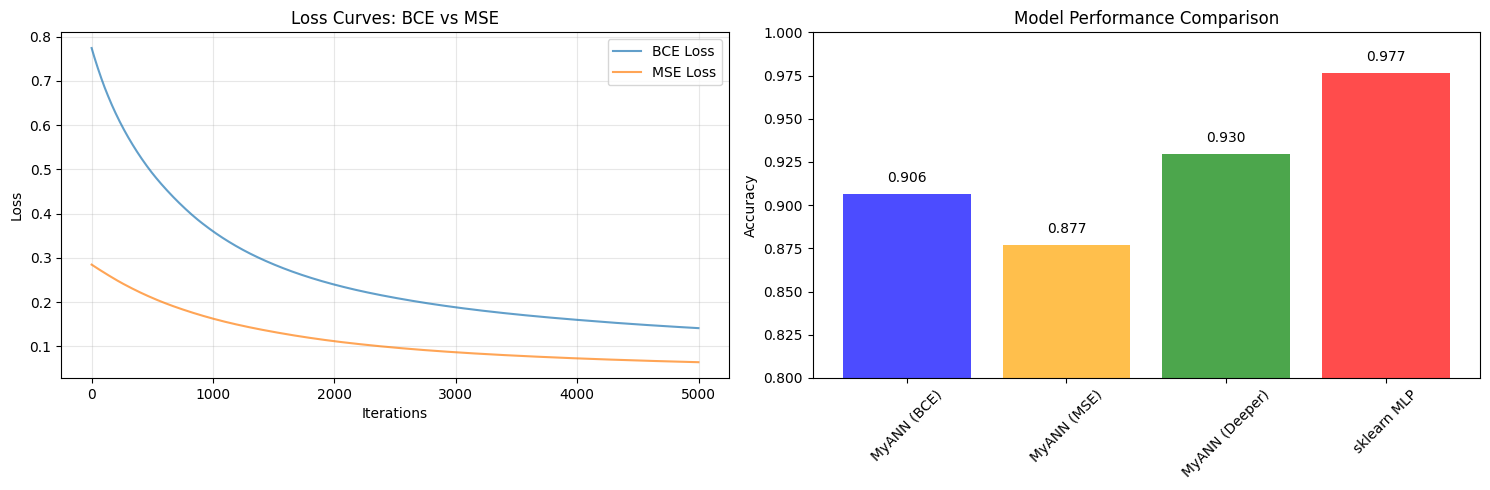


MODEL PERFORMANCE COMPARISON:
+--------------------------------------------------------------------+
| Model           | Accuracy | Precision | Recall   | F1-Score |
+--------------------------------------------------------------------+
| MyANN (BCE)     | 0.9064   | 0.9085   | 0.9064   | 0.9070   |
| MyANN (MSE)     | 0.8772   | 0.8848   | 0.8772   | 0.8785   |
| MyANN (Deeper)  | 0.9298   | 0.9298   | 0.9298   | 0.9298   |
| sklearn MLP     | 0.9766   | 0.9770   | 0.9766   | 0.9767   |
+--------------------------------------------------------------------+


In [15]:
print("Generating Visualizations and Final Analysis...")
print("-" * 40)

# Plot loss curves
plt.figure(figsize=(15, 5))

# Loss curves comparison
plt.subplot(1, 2, 1)
plt.plot(model1.costs_, label='BCE Loss', alpha=0.7)
plt.plot(model2.costs_, label='MSE Loss', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curves: BCE vs MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Model performance comparison
plt.subplot(1, 2, 2)
models = ['MyANN (BCE)', 'MyANN (MSE)', 'MyANN (Deeper)', 'sklearn MLP']
accuracies = [accuracy1, accuracy2, accuracy3, accuracy_mlp]

bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{accuracy:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Detailed performance comparison
from sklearn.metrics import precision_score, recall_score, f1_score

def get_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }

# Collect metrics for all models
metrics_list = [
    get_metrics(y_val, y_pred1, "MyANN (BCE)"),
    get_metrics(y_val, y_pred2, "MyANN (MSE)"),
    get_metrics(y_val, y_pred3, "MyANN (Deeper)"),
    get_metrics(y_val, y_pred_mlp, "sklearn MLP")
]

# Create comparison table
metrics_df = pd.DataFrame(metrics_list)
print("\nMODEL PERFORMANCE COMPARISON:")
print("+" + "-"*68 + "+")
print("| {:<15} | {:<8} | {:<8} | {:<8} | {:<8} |".format(
    "Model", "Accuracy", "Precision", "Recall", "F1-Score"))
print("+" + "-"*68 + "+")
for _, row in metrics_df.iterrows():
    print("| {:<15} | {:<8.4f} | {:<8.4f} | {:<8.4f} | {:<8.4f} |".format(
        row['Model'], row['Accuracy'], row['Precision'], row['Recall'], row['F1-Score']))
print("+" + "-"*68 + "+")